In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from ToyTrajectoryNet.utils import generate_steps, set_seeds, config_criterion
from ToyTrajectoryNet.models import make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train, train_ae
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.geo import setup_distance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn
from ToyTrajectoryNet.train import training_regimen
from tqdm.notebook import tqdm
import time, pickle, scprep

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load Petals Dataset

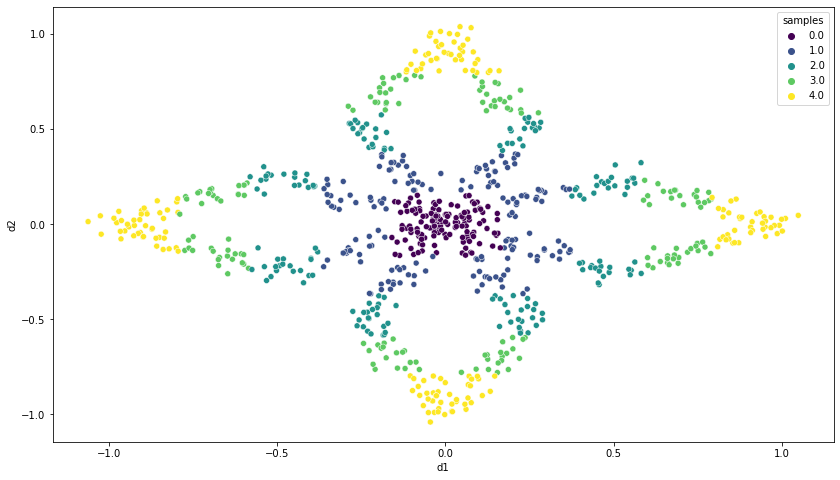

In [2]:
fig = plt.figure(figsize=(14, 8))
df = make_diamonds()
df.samples -=1
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [3]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [4]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 'random'

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [5]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = True
use_gae = False

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'gaussian'
rbf_length_scale=0.05
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 32
encoder_layers = [model_features, 8, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the thing

In [6]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.09, noise_max_scale=0.15, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss dist: 11.21817
Train loss dist: 8.27971
Train loss dist: 7.79898
Train loss dist: 6.52996
Train loss dist: 5.9795
Train loss dist: 5.93674
Train loss dist: 5.76265
Train loss dist: 5.44409
Train loss dist: 5.20892
Train loss dist: 5.18626
Train loss dist: 4.87336
Train loss dist: 4.71588
Train loss dist: 4.63918
Train loss dist: 4.49963
Train loss dist: 4.42991
Train loss dist: 4.35197
Train loss dist: 4.1221
Train loss dist: 4.15178
Train loss dist: 4.23204
Train loss dist: 3.85296
68.0140106678009


# Specify parameters

In [95]:
#export

from torchdiffeq import odeint_adjoint as odeint
import os, math, numpy as np
import torch
import torch.nn as nn
import torchsde

class ToySDEModel(nn.Module):
    """ 
    Neural SDE model
        func (nn.Module): drift term.
        gunc (nn.Module): diffusion term.
        method (str): method of the SDE solver.
        noise_type (str): Default to 'diagonal'. Noise to use with the diffusion.
        sde_type (str): Default to 'ito'. Type of SDE, either 'ito' or 'stratonovich'.
        dt (float|NoneType): Default to '0.1'. The step size. 
        use_norm (bool): Default to 'False'. Whether to keep in memory the norm of drift and diffusion. Used for the energy loss. 
        Method
        forward (Callable)
            x (torch.tensor): the initial sample
            t (torch.tensor) time points where we suppose x is from t[0]
            return the last sample or the whole seq.  
    """
    
    def __init__(self, func, method='euler', noise_type='diagonal', sde_type='ito', 
    gunc=None, dt=0.1, use_norm=False):
        super(ToySDEModel, self).__init__()        
        self.func = func
        self.method = method
        self.noise_type = noise_type
        self.sde_type = sde_type
        self.gunc = gunc
        self.alpha = None 
        self.use_norm = use_norm
        self.norm=[]
        self.dt = dt
        
    def f(self, t, y):
        return self.func(t, y)

    def g(self, t, y):
        return self.gunc(t, y)

    def forward(self, x, t, return_whole_sequence=False, dt=None):
        if self.use_norm:
            for time in t:
                _temp_norm = torch.linalg.norm(self.func(time,x)) + torch.linalg.norm(self.gunc(time,x))
                self.norm.append(_temp_norm)            
        dt = self.dt if self.dt is not None else 0.1 if dt is None else dt        
        x = torchsde.sdeint(self, x, t, method=self.method, dt=dt)
        x = x[-1] if not return_whole_sequence else x
        return x

In [135]:
from ToyTrajectoryNet.models import ToyODE, ToyModel
def make_model(
    feature_dims=5,
    layers=[64],
    output_dims=5,
    activation='ReLU',
    which='ode',
    method='rk4',
    rtol=None,
    atol=None,
    scales=None,
    n_aug=2,
    noise_type='diagonal', sde_type='ito',
    use_norm=False,
    use_cuda=False
):
    """
    Creates the 'ode' model or 'sde' model or the Geodesic Autoencoder. 
    See the parameters of the respective classes.
    """
    if which == 'ode':
        ode = ToyODE(feature_dims, layers, activation,scales,n_aug)
        model = ToyModel(ode,method,rtol, atol, use_norm=use_norm)
    elif which == 'sde':
        drift = ToyODE(feature_dims, layers, activation, scales=None, n_aug=n_aug)
        diffusion = ToyODE(feature_dims, layers, activation,scales=None,n_aug=0)
        model = ToySDEModel(drift, method, noise_type, sde_type, gunc=diffusion, use_norm=use_norm)
    else:
        model = ToyGeo(feature_dims, layers, output_dims, activation)
    if use_cuda:
        model.cuda()
    return model 

In [136]:
set_seeds(10)

#Directory where results are saved
exp_name = 'SDE-test'

# density loss knn
use_density_loss = False

# Weight of density (not percentage of total loss)
lambda_density = 5

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'
sde_type = 'ito' # The type of SDE either 'ito' or 'stratonovich'
ode_method = 'euler'#'rk4' # if sde_type = 'stratonovich':'euler_heun', 'heun' ... if  if sde_type = 'ito': 'euler', 'milstein', 'srk'. See 'torchsde' documentation

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]
use_penalty_energy = True
lambda_energy = 0.001
# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = None #Use to add noise in the ODE model. It is replaced by the diffusion in the SDE model.

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda,
    which='sde', method=ode_method, noise_type='diagonal', use_norm=use_penalty_energy,sde_type=sde_type
)

In [137]:
# Basically "batch size"
sample_size=(30, )

# Training specification
n_local_epochs = 0
n_epochs = 10
n_post_local_epochs = 0

criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 20
n_trajectories = 100
n_bins = 100

reverse=False

In [138]:
opts = {
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse': reverse
}

In [139]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [144]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    use_penalty=use_penalty_energy, lambda_energy=lambda_energy,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    # END: train params

    plot_every=1,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
#     local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses,
    reverse_schema=reverse
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [ ]:
for p in model.parameters():
    print(p.grad)

tensor([[ 4.1807e-04, -1.7735e-04, -7.0971e-04,  0.0000e+00,  0.0000e+00],
        [ 1.2255e-03,  3.8742e-03,  1.5035e-02,  0.0000e+00,  0.0000e+00],
        [ 3.7809e-03, -1.4082e-02,  7.8020e-02,  0.0000e+00,  0.0000e+00],
        [ 4.8915e-02,  1.3061e-02,  2.2894e-01,  0.0000e+00,  0.0000e+00],
        [ 1.0838e-03,  1.6243e-02, -8.2211e-02,  0.0000e+00,  0.0000e+00],
        [ 5.0220e-04, -4.1879e-04, -1.8435e-03,  0.0000e+00,  0.0000e+00],
        [-4.0276e-02,  3.7322e-02, -4.5346e-02,  0.0000e+00,  0.0000e+00],
        [-7.5558e-02,  4.2164e-03, -6.5989e-02,  0.0000e+00,  0.0000e+00],
        [-1.6571e-04,  1.9469e-05, -6.5436e-04,  0.0000e+00,  0.0000e+00],
        [ 2.1541e-02,  3.2878e-03, -5.6324e-02,  0.0000e+00,  0.0000e+00],
        [-3.0800e-04,  1.3339e-04, -4.4581e-04,  0.0000e+00,  0.0000e+00],
        [-2.0848e-02,  4.7735e-02, -8.3225e-02,  0.0000e+00,  0.0000e+00],
        [-3.1214e-02, -1.2567e-02,  1.9595e-01,  0.0000e+00,  0.0000e+00],
        [-4.0480e-04,  2.

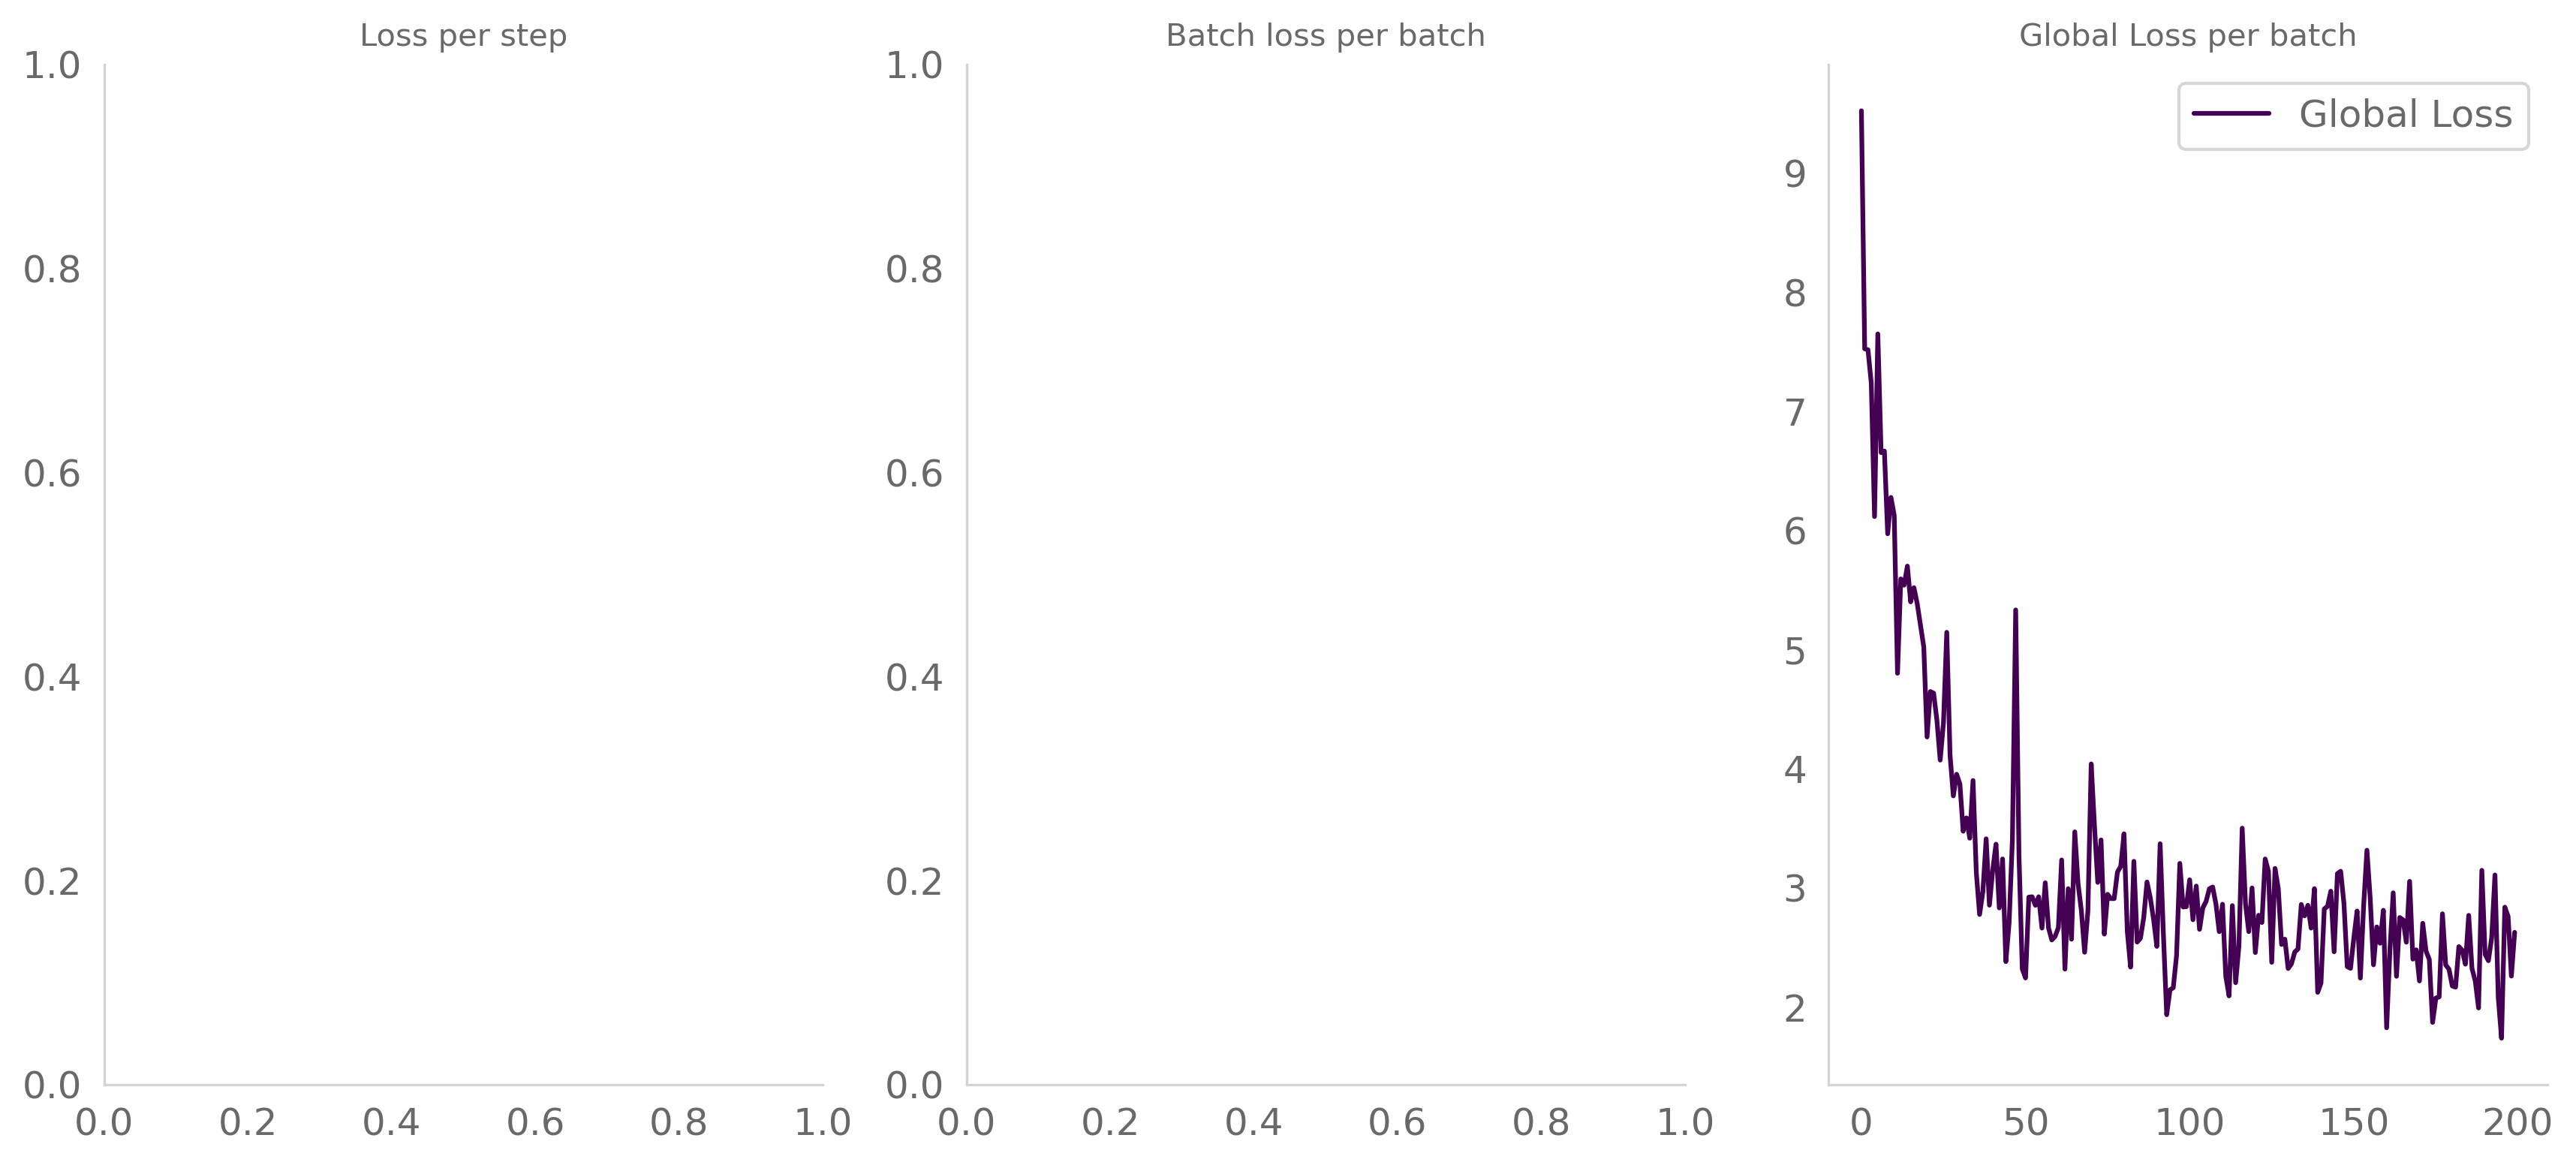

In [141]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [142]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

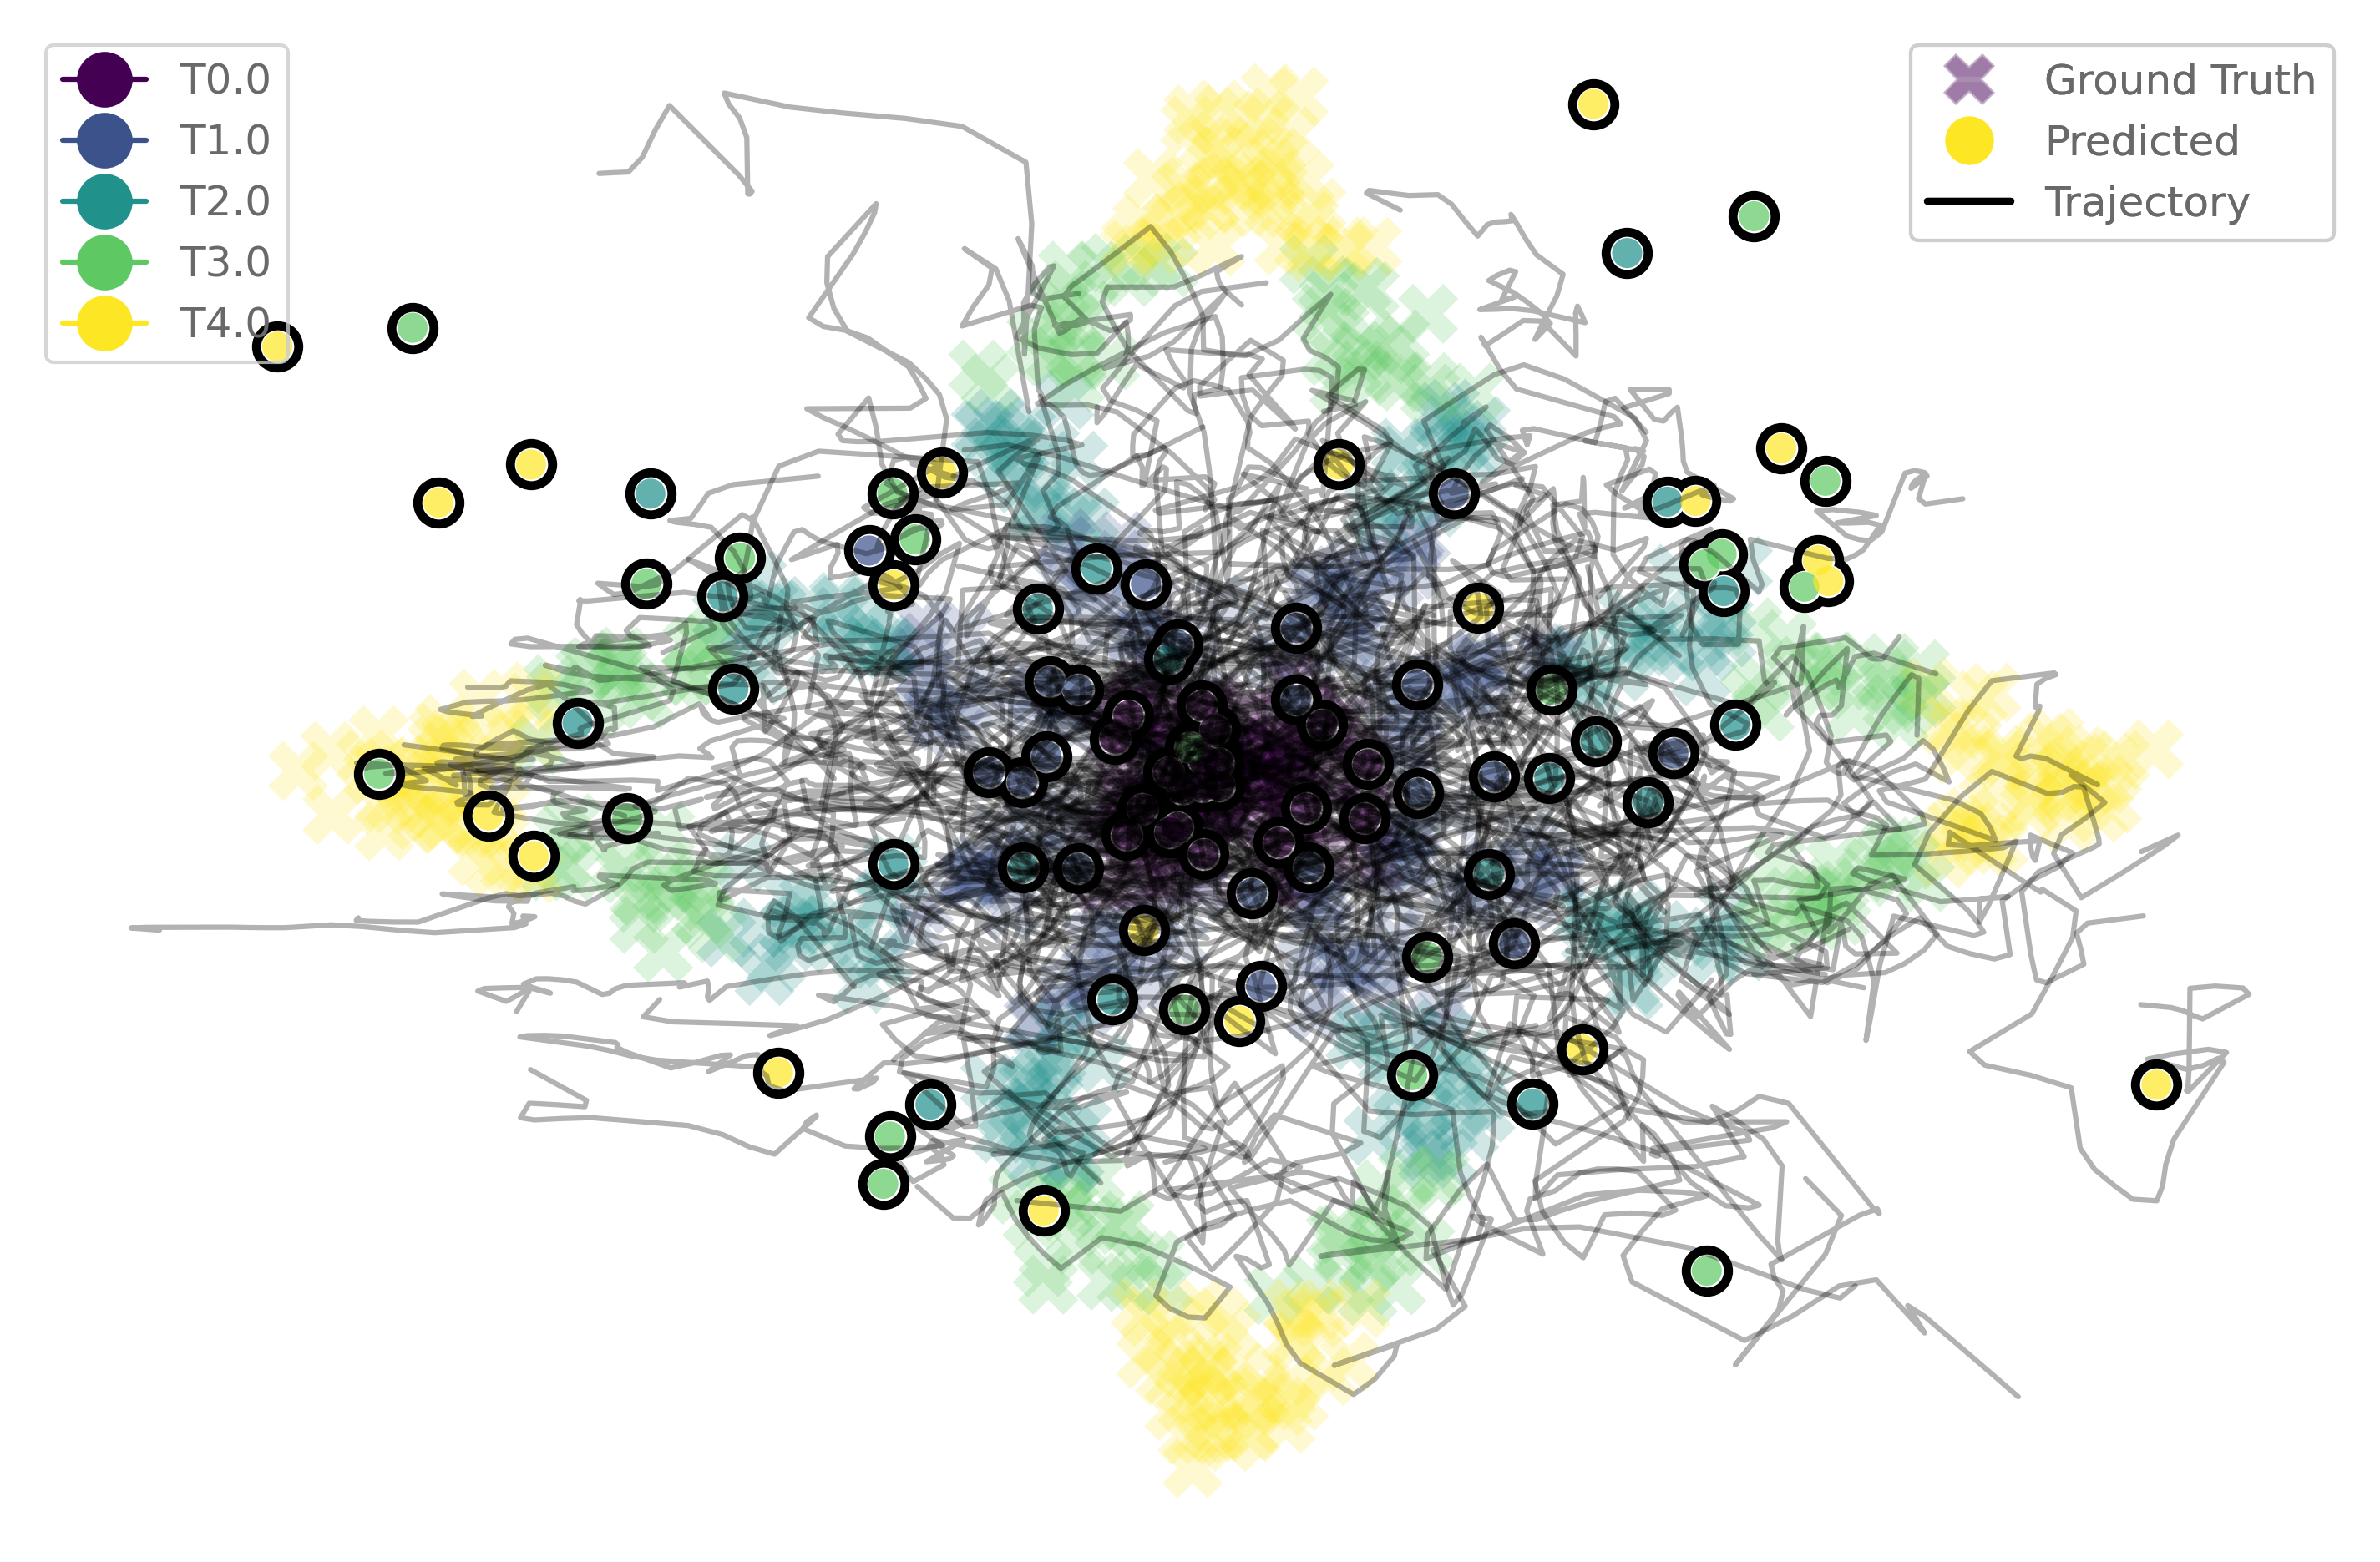

In [143]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)